In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame

from math import sqrt
from numpy import concatenate
from pandas import concat
from numpy import ndarray
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
case = pd.read_csv('data/new/case_maret_july.csv')

mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
mobility.set_index('date', inplace=True)

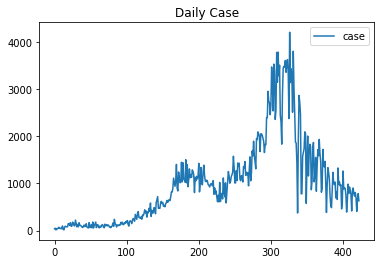

In [4]:
case.plot()
plt.title("Daily Case")
plt.show()

In [5]:
new_weather = weather.interpolate(method='spline', order=2)

new_date = weather[['date']]

new_weather.set_index('date', inplace=True)

In [6]:
case['date'] = case['date'].astype('datetime64[ns]')
case.set_index('date', inplace=True)
case.head()

,case
date,
2020-03-18,38
2020-03-19,50
2020-03-20,14
2020-03-21,44
2020-03-22,36


In [7]:
decompose = seasonal_decompose(case, model='additive', extrapolate_trend='freq')

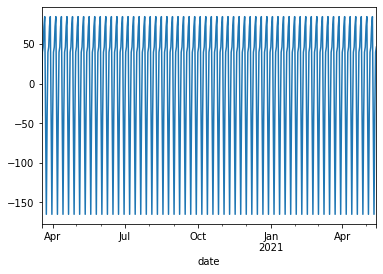

In [8]:
decompose.seasonal.plot()
plt.show()

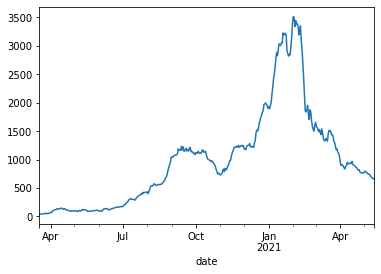

In [9]:
decompose.trend.plot()
plt.show()

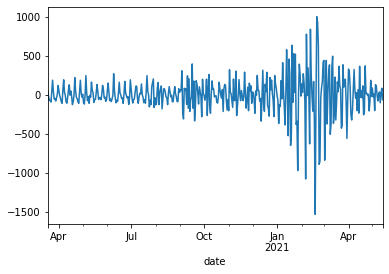

In [10]:
decompose.resid.plot()
plt.show()

In [11]:
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
actual = decompose.observed

In [12]:
new_trend = trend.to_frame()
new_seasonal = seasonal.to_frame()
new_residual = residual.to_frame()
new_actual = actual.to_frame()

In [13]:
# Ambil data untuk evaluasi
data_evaluasi = case[413:]

#total split data untuk LSTM
n_total = 412

# Split data ARIMA
train_ARIMA = new_trend[:412]
test_ARIMA = new_trend[412:]

# Parameter untuk LSTM
epooch_seasonal = 1000
epooch_residual = 1500
size_batch = 5

In [14]:
new_seasonal.reset_index(drop=True, inplace=True)
seasonal_data = pd.concat([new_date, new_seasonal], axis=1)
seasonal_data.set_index('date', inplace=True)

new_residual.reset_index(drop=True, inplace=True)
residual_data = pd.concat([new_date, new_residual], axis=1)
residual_data.set_index('date', inplace=True)

data_seasonal = pd.concat([seasonal_data, new_weather, mobility], axis=1)

data_residual = pd.concat([residual_data, new_weather, mobility], axis=1)

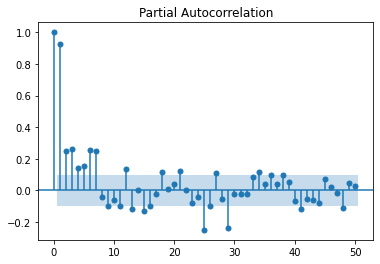

In [15]:
plot_pacf(case, lags=50)
plt.show()

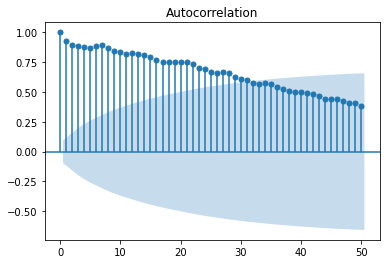

In [16]:
plot_acf(case, lags=50)
plt.show()

In [17]:
model = ARIMA(train_ARIMA, order=(1,0,1))
model_fit = model.fit()

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [18]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                  412
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2219.098
Date:                Wed, 15 Sep 2021   AIC                           4446.196
Time:                        11:40:08   BIC                           4462.280
Sample:                    03-18-2020   HQIC                          4452.558
                         - 05-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        997.2684    582.692      1.711      0.087    -144.787    2139.324
ar.L1          0.9962      0.002    400.447      0.000       0.991       1.001
ma.L1          0.3396      0.029     11.692      0.0

In [19]:
hasil = model_fit.forecast(10)
hasil= hasil.to_frame()

In [20]:
# frame as supervised learning
reframed_seasonal = series_to_supervised(data_seasonal, 1, 1)
reframed_residual = series_to_supervised(data_residual, 1, 1)

In [21]:
# drop columns we don't want to predict
reframed_seasonal.drop(reframed_seasonal.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)
reframed_residual.drop(reframed_residual.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)

In [22]:
# split into train and test sets
values_seasonal= reframed_seasonal.values
values_residual= reframed_residual.values

train_seasonal = values_seasonal[:n_total, :]
test_seasonal = values_seasonal[n_total:, :]

train_residual = values_residual[:n_total, :]
test_residual = values_residual[n_total:, :]

# split into input and outputs
seasonal_train_X, seasonal_train_y = train_seasonal[:, :-1], train_seasonal[:, -1]
seasonal_test_X, seasonal_test_y = test_seasonal[:, :-1], test_seasonal[:, -1]

residual_train_X, residual_train_y = train_residual[:, :-1], train_residual[:, -1]
residual_test_X, residual_test_y = test_residual[:, :-1], test_residual[:, -1]

# reshape input to be 3D [samples, timesteps, features]
seasonal_train_X = seasonal_train_X.reshape((seasonal_train_X.shape[0], 1, seasonal_train_X.shape[1]))
seasonal_test_X = seasonal_test_X.reshape((seasonal_test_X.shape[0], 1, seasonal_test_X.shape[1]))

residual_train_X = residual_train_X.reshape((residual_train_X.shape[0], 1, residual_train_X.shape[1]))
residual_test_X = residual_test_X.reshape((residual_test_X.shape[0], 1, residual_test_X.shape[1]))


#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


Epoch 1/1000
83/83 - 1s - loss: 68.6914 - val_loss: 59.9120
Epoch 2/1000
83/83 - 0s - loss: 67.9541 - val_loss: 59.1444
Epoch 3/1000
83/83 - 0s - loss: 67.1866 - val_loss: 58.0805
Epoch 4/1000
83/83 - 0s - loss: 66.2040 - val_loss: 57.2600
Epoch 5/1000
83/83 - 0s - loss: 65.4955 - val_loss: 56.5531
Epoch 6/1000
83/83 - 0s - loss: 64.6431 - val_loss: 55.5893
Epoch 7/1000
83/83 - 0s - loss: 63.7834 - val_loss: 54.8982
Epoch 8/1000
83/83 - 0s - loss: 62.8216 - val_loss: 53.8745
Epoch 9/1000
83/83 - 0s - loss: 61.9369 - val_loss: 53.1459
Epoch 10/1000
83/83 - 0s - loss: 60.9822 - val_loss: 52.5145
Epoch 11/1000
83/83 - 0s - loss: 60.1681 - val_loss: 51.6451
Epoch 12/1000
83/83 - 0s - loss: 59.2434 - val_loss: 50.8297
Epoch 13/1000
83/83 - 0s - loss: 58.3168 - val_loss: 49.8702
Epoch 14/1000
83/83 - 0s - loss: 57.4247 - val_loss: 49.2145
Epoch 15/1000
83/83 - 0s - loss: 56.5098 - val_loss: 48.3392
Epoch 16/1000
83/83 - 0s - loss: 55.6230 - val_loss: 47.6278
Epoch 17/1000
83/83 - 0s - loss: 

Epoch 135/1000
83/83 - 0s - loss: 28.9365 - val_loss: 34.2820
Epoch 136/1000
83/83 - 0s - loss: 28.9700 - val_loss: 34.3178
Epoch 137/1000
83/83 - 0s - loss: 28.8718 - val_loss: 34.3436
Epoch 138/1000
83/83 - 0s - loss: 28.9542 - val_loss: 34.1180
Epoch 139/1000
83/83 - 0s - loss: 28.9657 - val_loss: 34.4815
Epoch 140/1000
83/83 - 0s - loss: 28.8613 - val_loss: 33.9503
Epoch 141/1000
83/83 - 0s - loss: 28.8270 - val_loss: 34.9365
Epoch 142/1000
83/83 - 0s - loss: 28.7634 - val_loss: 34.4038
Epoch 143/1000
83/83 - 0s - loss: 28.8286 - val_loss: 34.5641
Epoch 144/1000
83/83 - 0s - loss: 28.7599 - val_loss: 34.5227
Epoch 145/1000
83/83 - 0s - loss: 28.6606 - val_loss: 34.4510
Epoch 146/1000
83/83 - 0s - loss: 28.6632 - val_loss: 34.3941
Epoch 147/1000
83/83 - 0s - loss: 28.6464 - val_loss: 34.2693
Epoch 148/1000
83/83 - 0s - loss: 28.6241 - val_loss: 34.3503
Epoch 149/1000
83/83 - 0s - loss: 28.5728 - val_loss: 34.1051
Epoch 150/1000
83/83 - 0s - loss: 28.5906 - val_loss: 33.9345
Epoch 15

83/83 - 0s - loss: 25.2931 - val_loss: 27.2475
Epoch 268/1000
83/83 - 0s - loss: 25.2432 - val_loss: 27.2246
Epoch 269/1000
83/83 - 0s - loss: 25.1808 - val_loss: 27.3579
Epoch 270/1000
83/83 - 0s - loss: 25.1434 - val_loss: 27.3512
Epoch 271/1000
83/83 - 0s - loss: 25.1311 - val_loss: 27.3931
Epoch 272/1000
83/83 - 0s - loss: 25.1869 - val_loss: 27.2936
Epoch 273/1000
83/83 - 0s - loss: 25.1014 - val_loss: 27.2764
Epoch 274/1000
83/83 - 0s - loss: 25.0446 - val_loss: 27.2235
Epoch 275/1000
83/83 - 0s - loss: 24.9926 - val_loss: 27.3473
Epoch 276/1000
83/83 - 0s - loss: 24.9857 - val_loss: 27.0907
Epoch 277/1000
83/83 - 0s - loss: 24.9433 - val_loss: 26.9437
Epoch 278/1000
83/83 - 0s - loss: 24.9334 - val_loss: 27.3008
Epoch 279/1000
83/83 - 0s - loss: 24.8705 - val_loss: 26.8667
Epoch 280/1000
83/83 - 0s - loss: 24.8504 - val_loss: 26.8901
Epoch 281/1000
83/83 - 0s - loss: 24.8152 - val_loss: 26.6652
Epoch 282/1000
83/83 - 0s - loss: 24.7975 - val_loss: 26.5770
Epoch 283/1000
83/83 - 

Epoch 400/1000
83/83 - 0s - loss: 21.3044 - val_loss: 23.4452
Epoch 401/1000
83/83 - 0s - loss: 21.3451 - val_loss: 23.8377
Epoch 402/1000
83/83 - 0s - loss: 21.3324 - val_loss: 23.9393
Epoch 403/1000
83/83 - 0s - loss: 21.3401 - val_loss: 23.9261
Epoch 404/1000
83/83 - 0s - loss: 21.2453 - val_loss: 24.4901
Epoch 405/1000
83/83 - 0s - loss: 21.2913 - val_loss: 24.7347
Epoch 406/1000
83/83 - 0s - loss: 21.1876 - val_loss: 23.6471
Epoch 407/1000
83/83 - 0s - loss: 21.1515 - val_loss: 23.4761
Epoch 408/1000
83/83 - 0s - loss: 21.1855 - val_loss: 23.3655
Epoch 409/1000
83/83 - 0s - loss: 21.1333 - val_loss: 23.8394
Epoch 410/1000
83/83 - 0s - loss: 21.1211 - val_loss: 23.7163
Epoch 411/1000
83/83 - 0s - loss: 21.0396 - val_loss: 23.1045
Epoch 412/1000
83/83 - 0s - loss: 21.0115 - val_loss: 23.0835
Epoch 413/1000
83/83 - 0s - loss: 21.0678 - val_loss: 23.7096
Epoch 414/1000
83/83 - 0s - loss: 20.9971 - val_loss: 23.7484
Epoch 415/1000
83/83 - 0s - loss: 20.9958 - val_loss: 23.5569
Epoch 41

83/83 - 0s - loss: 18.1175 - val_loss: 20.7576
Epoch 533/1000
83/83 - 0s - loss: 17.9678 - val_loss: 20.6500
Epoch 534/1000
83/83 - 0s - loss: 17.9470 - val_loss: 20.3167
Epoch 535/1000
83/83 - 0s - loss: 17.9246 - val_loss: 20.4639
Epoch 536/1000
83/83 - 0s - loss: 17.9036 - val_loss: 20.3143
Epoch 537/1000
83/83 - 0s - loss: 17.8818 - val_loss: 20.4517
Epoch 538/1000
83/83 - 0s - loss: 17.8670 - val_loss: 20.2488
Epoch 539/1000
83/83 - 0s - loss: 18.0552 - val_loss: 20.2744
Epoch 540/1000
83/83 - 0s - loss: 17.8904 - val_loss: 20.0683
Epoch 541/1000
83/83 - 0s - loss: 17.8118 - val_loss: 20.4071
Epoch 542/1000
83/83 - 0s - loss: 17.8192 - val_loss: 20.0826
Epoch 543/1000
83/83 - 0s - loss: 17.7486 - val_loss: 20.3509
Epoch 544/1000
83/83 - 0s - loss: 17.7352 - val_loss: 20.2076
Epoch 545/1000
83/83 - 0s - loss: 17.7425 - val_loss: 20.2094
Epoch 546/1000
83/83 - 0s - loss: 17.6772 - val_loss: 20.1932
Epoch 547/1000
83/83 - 0s - loss: 17.6566 - val_loss: 20.1998
Epoch 548/1000
83/83 - 

Epoch 665/1000
83/83 - 0s - loss: 14.6364 - val_loss: 18.2250
Epoch 666/1000
83/83 - 0s - loss: 14.6464 - val_loss: 18.0131
Epoch 667/1000
83/83 - 0s - loss: 14.6155 - val_loss: 18.1382
Epoch 668/1000
83/83 - 0s - loss: 14.5575 - val_loss: 18.0305
Epoch 669/1000
83/83 - 0s - loss: 14.5248 - val_loss: 18.0530
Epoch 670/1000
83/83 - 0s - loss: 14.5220 - val_loss: 18.1504
Epoch 671/1000
83/83 - 0s - loss: 14.4584 - val_loss: 18.0561
Epoch 672/1000
83/83 - 0s - loss: 14.5023 - val_loss: 18.3588
Epoch 673/1000
83/83 - 0s - loss: 14.4137 - val_loss: 17.9040
Epoch 674/1000
83/83 - 0s - loss: 14.4051 - val_loss: 17.7855
Epoch 675/1000
83/83 - 0s - loss: 14.3657 - val_loss: 18.0046
Epoch 676/1000
83/83 - 0s - loss: 14.3823 - val_loss: 18.1620
Epoch 677/1000
83/83 - 0s - loss: 14.3347 - val_loss: 17.9342
Epoch 678/1000
83/83 - 0s - loss: 14.2970 - val_loss: 17.9066
Epoch 679/1000
83/83 - 0s - loss: 14.2540 - val_loss: 17.8598
Epoch 680/1000
83/83 - 0s - loss: 14.2781 - val_loss: 18.0497
Epoch 68

83/83 - 0s - loss: 10.8524 - val_loss: 17.2855
Epoch 798/1000
83/83 - 0s - loss: 10.9091 - val_loss: 17.1981
Epoch 799/1000
83/83 - 0s - loss: 10.7739 - val_loss: 16.7453
Epoch 800/1000
83/83 - 0s - loss: 10.8181 - val_loss: 16.7823
Epoch 801/1000
83/83 - 0s - loss: 10.7993 - val_loss: 17.2798
Epoch 802/1000
83/83 - 0s - loss: 10.7481 - val_loss: 17.1467
Epoch 803/1000
83/83 - 0s - loss: 10.7426 - val_loss: 16.9427
Epoch 804/1000
83/83 - 0s - loss: 10.6282 - val_loss: 16.8965
Epoch 805/1000
83/83 - 0s - loss: 10.6926 - val_loss: 16.9034
Epoch 806/1000
83/83 - 0s - loss: 10.5707 - val_loss: 16.9958
Epoch 807/1000
83/83 - 0s - loss: 10.6177 - val_loss: 16.7609
Epoch 808/1000
83/83 - 0s - loss: 10.6230 - val_loss: 16.5850
Epoch 809/1000
83/83 - 0s - loss: 10.5335 - val_loss: 16.8094
Epoch 810/1000
83/83 - 0s - loss: 10.4555 - val_loss: 16.5880
Epoch 811/1000
83/83 - 0s - loss: 10.3278 - val_loss: 16.6802
Epoch 812/1000
83/83 - 0s - loss: 10.2566 - val_loss: 16.7022
Epoch 813/1000
83/83 - 

Epoch 932/1000
83/83 - 0s - loss: 6.6809 - val_loss: 14.6693
Epoch 933/1000
83/83 - 0s - loss: 6.4846 - val_loss: 14.4655
Epoch 934/1000
83/83 - 0s - loss: 6.5949 - val_loss: 14.4426
Epoch 935/1000
83/83 - 0s - loss: 6.5781 - val_loss: 14.5435
Epoch 936/1000
83/83 - 0s - loss: 6.5242 - val_loss: 14.5233
Epoch 937/1000
83/83 - 0s - loss: 6.4972 - val_loss: 14.5387
Epoch 938/1000
83/83 - 0s - loss: 6.4721 - val_loss: 14.5315
Epoch 939/1000
83/83 - 0s - loss: 6.4469 - val_loss: 14.6209
Epoch 940/1000
83/83 - 0s - loss: 6.4002 - val_loss: 14.5992
Epoch 941/1000
83/83 - 0s - loss: 6.4115 - val_loss: 14.6506
Epoch 942/1000
83/83 - 0s - loss: 6.3856 - val_loss: 14.7032
Epoch 943/1000
83/83 - 0s - loss: 6.2163 - val_loss: 14.6688
Epoch 944/1000
83/83 - 0s - loss: 6.2929 - val_loss: 14.6554
Epoch 945/1000
83/83 - 0s - loss: 6.2439 - val_loss: 14.6483
Epoch 946/1000
83/83 - 0s - loss: 6.2184 - val_loss: 14.7482
Epoch 947/1000
83/83 - 0s - loss: 6.1769 - val_loss: 14.7600
Epoch 948/1000
83/83 - 0

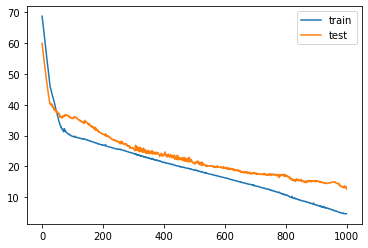

In [23]:
# LSTM model untuk seasonal
model1 = Sequential()
model1.add(LSTM(50, input_shape=(seasonal_train_X.shape[1], seasonal_train_X.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
# fit network
history = model1.fit(seasonal_train_X, seasonal_train_y, epochs=epooch_seasonal, batch_size=size_batch, validation_data=(seasonal_test_X, seasonal_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
# make a prediction
yhat_seasonality = model1.predict(seasonal_test_X)
yhat_seasonality

array([[ -40.117043],
       [ -45.658035],
       [  45.422615],
       [  71.94655 ],
       [  84.48303 ],
       [ -36.555855],
       [-170.55188 ],
       [ -40.095383],
       [   4.88021 ],
       [  45.288536]], dtype=float32)

Epoch 1/1500
83/83 - 1s - loss: 151.7375 - val_loss: 65.0244
Epoch 2/1500
83/83 - 0s - loss: 151.5967 - val_loss: 65.1502
Epoch 3/1500
83/83 - 0s - loss: 151.5114 - val_loss: 65.2994
Epoch 4/1500
83/83 - 0s - loss: 151.4168 - val_loss: 65.5035
Epoch 5/1500
83/83 - 0s - loss: 151.3423 - val_loss: 65.5435
Epoch 6/1500
83/83 - 0s - loss: 151.2703 - val_loss: 65.6925
Epoch 7/1500
83/83 - 0s - loss: 151.2091 - val_loss: 65.8358
Epoch 8/1500
83/83 - 0s - loss: 151.1462 - val_loss: 66.1002
Epoch 9/1500
83/83 - 0s - loss: 151.0746 - val_loss: 66.1603
Epoch 10/1500
83/83 - 0s - loss: 151.0069 - val_loss: 66.0433
Epoch 11/1500
83/83 - 0s - loss: 150.9490 - val_loss: 66.2962
Epoch 12/1500
83/83 - 0s - loss: 150.8740 - val_loss: 66.4242
Epoch 13/1500
83/83 - 0s - loss: 150.8013 - val_loss: 66.6569
Epoch 14/1500
83/83 - 0s - loss: 150.7555 - val_loss: 66.6201
Epoch 15/1500
83/83 - 0s - loss: 150.6719 - val_loss: 66.7468
Epoch 16/1500
83/83 - 0s - loss: 150.6458 - val_loss: 66.8160
Epoch 17/1500
83/

83/83 - 0s - loss: 146.5997 - val_loss: 71.9562
Epoch 128/1500
83/83 - 0s - loss: 146.5739 - val_loss: 71.8505
Epoch 129/1500
83/83 - 0s - loss: 146.5611 - val_loss: 71.7303
Epoch 130/1500
83/83 - 0s - loss: 146.5250 - val_loss: 71.7037
Epoch 131/1500
83/83 - 0s - loss: 146.5141 - val_loss: 71.5823
Epoch 132/1500
83/83 - 0s - loss: 146.4974 - val_loss: 71.6938
Epoch 133/1500
83/83 - 0s - loss: 146.5009 - val_loss: 71.8260
Epoch 134/1500
83/83 - 0s - loss: 146.4865 - val_loss: 71.6886
Epoch 135/1500
83/83 - 0s - loss: 146.4579 - val_loss: 71.7573
Epoch 136/1500
83/83 - 0s - loss: 146.4360 - val_loss: 71.7279
Epoch 137/1500
83/83 - 0s - loss: 146.4271 - val_loss: 71.7902
Epoch 138/1500
83/83 - 0s - loss: 146.4232 - val_loss: 71.9526
Epoch 139/1500
83/83 - 0s - loss: 146.4118 - val_loss: 71.8731
Epoch 140/1500
83/83 - 0s - loss: 146.4023 - val_loss: 71.7499
Epoch 141/1500
83/83 - 0s - loss: 146.3789 - val_loss: 71.8634
Epoch 142/1500
83/83 - 0s - loss: 146.4326 - val_loss: 72.1528
Epoch 1

Epoch 258/1500
83/83 - 0s - loss: 144.6332 - val_loss: 72.5890
Epoch 259/1500
83/83 - 0s - loss: 144.5986 - val_loss: 72.7026
Epoch 260/1500
83/83 - 0s - loss: 144.6017 - val_loss: 72.8226
Epoch 261/1500
83/83 - 0s - loss: 144.6311 - val_loss: 72.9133
Epoch 262/1500
83/83 - 0s - loss: 144.6037 - val_loss: 72.8555
Epoch 263/1500
83/83 - 0s - loss: 144.5593 - val_loss: 72.7056
Epoch 264/1500
83/83 - 0s - loss: 144.5569 - val_loss: 72.6651
Epoch 265/1500
83/83 - 0s - loss: 144.5978 - val_loss: 72.8422
Epoch 266/1500
83/83 - 0s - loss: 144.5581 - val_loss: 72.3627
Epoch 267/1500
83/83 - 0s - loss: 144.5664 - val_loss: 72.5882
Epoch 268/1500
83/83 - 0s - loss: 144.5293 - val_loss: 72.3461
Epoch 269/1500
83/83 - 0s - loss: 144.4867 - val_loss: 72.2208
Epoch 270/1500
83/83 - 0s - loss: 144.5215 - val_loss: 72.7628
Epoch 271/1500
83/83 - 0s - loss: 144.5166 - val_loss: 72.7841
Epoch 272/1500
83/83 - 0s - loss: 144.4131 - val_loss: 72.4424
Epoch 273/1500
83/83 - 0s - loss: 144.4613 - val_loss: 

83/83 - 0s - loss: 142.7950 - val_loss: 69.2894
Epoch 389/1500
83/83 - 0s - loss: 142.8381 - val_loss: 69.4403
Epoch 390/1500
83/83 - 0s - loss: 142.8365 - val_loss: 69.0782
Epoch 391/1500
83/83 - 0s - loss: 142.7686 - val_loss: 68.9074
Epoch 392/1500
83/83 - 0s - loss: 142.7248 - val_loss: 69.0206
Epoch 393/1500
83/83 - 0s - loss: 142.7536 - val_loss: 69.1001
Epoch 394/1500
83/83 - 0s - loss: 142.7762 - val_loss: 69.1352
Epoch 395/1500
83/83 - 0s - loss: 142.7183 - val_loss: 69.2790
Epoch 396/1500
83/83 - 0s - loss: 142.7063 - val_loss: 68.6792
Epoch 397/1500
83/83 - 0s - loss: 142.6950 - val_loss: 69.5246
Epoch 398/1500
83/83 - 0s - loss: 142.6466 - val_loss: 68.9939
Epoch 399/1500
83/83 - 0s - loss: 142.6403 - val_loss: 69.3313
Epoch 400/1500
83/83 - 0s - loss: 142.6359 - val_loss: 69.0673
Epoch 401/1500
83/83 - 0s - loss: 142.6967 - val_loss: 69.6804
Epoch 402/1500
83/83 - 0s - loss: 142.5996 - val_loss: 68.8499
Epoch 403/1500
83/83 - 0s - loss: 142.6328 - val_loss: 69.5509
Epoch 4

Epoch 519/1500
83/83 - 0s - loss: 141.2421 - val_loss: 67.4523
Epoch 520/1500
83/83 - 0s - loss: 141.2899 - val_loss: 68.5686
Epoch 521/1500
83/83 - 0s - loss: 141.2099 - val_loss: 67.0988
Epoch 522/1500
83/83 - 0s - loss: 141.2135 - val_loss: 67.0198
Epoch 523/1500
83/83 - 0s - loss: 141.1788 - val_loss: 67.1598
Epoch 524/1500
83/83 - 0s - loss: 141.1137 - val_loss: 67.2530
Epoch 525/1500
83/83 - 0s - loss: 141.1396 - val_loss: 67.9003
Epoch 526/1500
83/83 - 0s - loss: 141.1189 - val_loss: 67.6368
Epoch 527/1500
83/83 - 0s - loss: 141.1807 - val_loss: 68.1563
Epoch 528/1500
83/83 - 0s - loss: 141.1835 - val_loss: 67.7261
Epoch 529/1500
83/83 - 0s - loss: 141.0986 - val_loss: 69.7581
Epoch 530/1500
83/83 - 0s - loss: 141.1443 - val_loss: 67.4567
Epoch 531/1500
83/83 - 0s - loss: 141.1585 - val_loss: 67.4528
Epoch 532/1500
83/83 - 0s - loss: 141.0632 - val_loss: 67.1341
Epoch 533/1500
83/83 - 0s - loss: 141.0301 - val_loss: 67.5964
Epoch 534/1500
83/83 - 0s - loss: 141.1343 - val_loss: 

Epoch 650/1500
83/83 - 0s - loss: 139.7400 - val_loss: 68.0940
Epoch 651/1500
83/83 - 0s - loss: 139.6821 - val_loss: 69.2021
Epoch 652/1500
83/83 - 0s - loss: 139.5641 - val_loss: 68.7148
Epoch 653/1500
83/83 - 0s - loss: 139.6784 - val_loss: 69.6313
Epoch 654/1500
83/83 - 0s - loss: 139.7197 - val_loss: 68.1843
Epoch 655/1500
83/83 - 0s - loss: 139.6500 - val_loss: 68.7621
Epoch 656/1500
83/83 - 0s - loss: 139.6135 - val_loss: 69.0933
Epoch 657/1500
83/83 - 0s - loss: 139.5576 - val_loss: 68.6799
Epoch 658/1500
83/83 - 0s - loss: 139.6043 - val_loss: 69.0348
Epoch 659/1500
83/83 - 0s - loss: 139.5666 - val_loss: 68.9605
Epoch 660/1500
83/83 - 0s - loss: 139.5403 - val_loss: 69.0596
Epoch 661/1500
83/83 - 0s - loss: 139.6470 - val_loss: 68.3649
Epoch 662/1500
83/83 - 0s - loss: 139.5025 - val_loss: 68.7003
Epoch 663/1500
83/83 - 0s - loss: 139.6000 - val_loss: 68.9255
Epoch 664/1500
83/83 - 0s - loss: 139.5502 - val_loss: 68.2954
Epoch 665/1500
83/83 - 0s - loss: 139.4862 - val_loss: 

83/83 - 0s - loss: 138.1592 - val_loss: 69.5467
Epoch 781/1500
83/83 - 0s - loss: 138.1254 - val_loss: 68.9148
Epoch 782/1500
83/83 - 0s - loss: 138.2169 - val_loss: 70.5156
Epoch 783/1500
83/83 - 0s - loss: 138.1462 - val_loss: 68.9530
Epoch 784/1500
83/83 - 0s - loss: 138.1358 - val_loss: 70.0016
Epoch 785/1500
83/83 - 0s - loss: 138.1096 - val_loss: 69.8184
Epoch 786/1500
83/83 - 0s - loss: 138.0599 - val_loss: 68.5080
Epoch 787/1500
83/83 - 0s - loss: 138.0928 - val_loss: 71.6142
Epoch 788/1500
83/83 - 0s - loss: 138.0213 - val_loss: 68.5324
Epoch 789/1500
83/83 - 0s - loss: 138.1298 - val_loss: 70.8941
Epoch 790/1500
83/83 - 0s - loss: 138.0066 - val_loss: 69.9357
Epoch 791/1500
83/83 - 0s - loss: 137.9919 - val_loss: 68.8273
Epoch 792/1500
83/83 - 0s - loss: 138.0003 - val_loss: 68.3890
Epoch 793/1500
83/83 - 0s - loss: 138.0075 - val_loss: 71.2491
Epoch 794/1500
83/83 - 0s - loss: 137.9846 - val_loss: 69.5835
Epoch 795/1500
83/83 - 0s - loss: 138.0704 - val_loss: 68.9561
Epoch 7

Epoch 911/1500
83/83 - 0s - loss: 136.8197 - val_loss: 70.8322
Epoch 912/1500
83/83 - 0s - loss: 136.8090 - val_loss: 69.5715
Epoch 913/1500
83/83 - 0s - loss: 136.9341 - val_loss: 68.7741
Epoch 914/1500
83/83 - 0s - loss: 136.9112 - val_loss: 70.2829
Epoch 915/1500
83/83 - 0s - loss: 136.8937 - val_loss: 69.2051
Epoch 916/1500
83/83 - 0s - loss: 136.8671 - val_loss: 69.6806
Epoch 917/1500
83/83 - 0s - loss: 136.8427 - val_loss: 69.4993
Epoch 918/1500
83/83 - 0s - loss: 136.8455 - val_loss: 67.3664
Epoch 919/1500
83/83 - 0s - loss: 136.8062 - val_loss: 70.3673
Epoch 920/1500
83/83 - 0s - loss: 136.9575 - val_loss: 69.7356
Epoch 921/1500
83/83 - 0s - loss: 137.0064 - val_loss: 69.6787
Epoch 922/1500
83/83 - 0s - loss: 136.8314 - val_loss: 70.6226
Epoch 923/1500
83/83 - 0s - loss: 137.0450 - val_loss: 71.8237
Epoch 924/1500
83/83 - 0s - loss: 136.8798 - val_loss: 65.5400
Epoch 925/1500
83/83 - 0s - loss: 137.0256 - val_loss: 64.3871
Epoch 926/1500
83/83 - 0s - loss: 136.9103 - val_loss: 

Epoch 1041/1500
83/83 - 0s - loss: 135.7205 - val_loss: 65.3078
Epoch 1042/1500
83/83 - 0s - loss: 135.6878 - val_loss: 65.7784
Epoch 1043/1500
83/83 - 0s - loss: 135.8196 - val_loss: 64.8418
Epoch 1044/1500
83/83 - 0s - loss: 135.7570 - val_loss: 63.8346
Epoch 1045/1500
83/83 - 0s - loss: 135.6765 - val_loss: 67.0863
Epoch 1046/1500
83/83 - 0s - loss: 135.6663 - val_loss: 68.2425
Epoch 1047/1500
83/83 - 0s - loss: 135.6008 - val_loss: 68.8613
Epoch 1048/1500
83/83 - 0s - loss: 135.5057 - val_loss: 65.3623
Epoch 1049/1500
83/83 - 0s - loss: 135.9460 - val_loss: 65.5026
Epoch 1050/1500
83/83 - 0s - loss: 135.9541 - val_loss: 64.3586
Epoch 1051/1500
83/83 - 0s - loss: 135.7526 - val_loss: 65.8138
Epoch 1052/1500
83/83 - 0s - loss: 135.6694 - val_loss: 65.4701
Epoch 1053/1500
83/83 - 0s - loss: 135.7271 - val_loss: 65.0047
Epoch 1054/1500
83/83 - 0s - loss: 135.8693 - val_loss: 66.3945
Epoch 1055/1500
83/83 - 0s - loss: 135.5126 - val_loss: 65.4485
Epoch 1056/1500
83/83 - 0s - loss: 135.5

83/83 - 0s - loss: 134.8976 - val_loss: 66.9873
Epoch 1170/1500
83/83 - 0s - loss: 134.7427 - val_loss: 64.1530
Epoch 1171/1500
83/83 - 0s - loss: 134.8371 - val_loss: 66.4421
Epoch 1172/1500
83/83 - 0s - loss: 134.6662 - val_loss: 66.6525
Epoch 1173/1500
83/83 - 0s - loss: 134.7274 - val_loss: 68.6659
Epoch 1174/1500
83/83 - 0s - loss: 134.6883 - val_loss: 69.3200
Epoch 1175/1500
83/83 - 0s - loss: 134.4849 - val_loss: 68.8078
Epoch 1176/1500
83/83 - 0s - loss: 134.5615 - val_loss: 69.0676
Epoch 1177/1500
83/83 - 0s - loss: 134.5363 - val_loss: 69.0920
Epoch 1178/1500
83/83 - 0s - loss: 134.5616 - val_loss: 69.7083
Epoch 1179/1500
83/83 - 0s - loss: 134.3542 - val_loss: 66.0611
Epoch 1180/1500
83/83 - 0s - loss: 134.8576 - val_loss: 65.1071
Epoch 1181/1500
83/83 - 0s - loss: 134.7135 - val_loss: 66.2638
Epoch 1182/1500
83/83 - 0s - loss: 134.6015 - val_loss: 64.9387
Epoch 1183/1500
83/83 - 0s - loss: 134.6034 - val_loss: 66.8682
Epoch 1184/1500
83/83 - 0s - loss: 134.5168 - val_loss: 

Epoch 1298/1500
83/83 - 0s - loss: 133.6016 - val_loss: 68.4128
Epoch 1299/1500
83/83 - 0s - loss: 133.7874 - val_loss: 68.8305
Epoch 1300/1500
83/83 - 0s - loss: 133.6399 - val_loss: 65.2037
Epoch 1301/1500
83/83 - 0s - loss: 133.8903 - val_loss: 68.6508
Epoch 1302/1500
83/83 - 0s - loss: 133.7744 - val_loss: 68.2371
Epoch 1303/1500
83/83 - 0s - loss: 133.5628 - val_loss: 65.2531
Epoch 1304/1500
83/83 - 0s - loss: 133.7202 - val_loss: 65.7935
Epoch 1305/1500
83/83 - 0s - loss: 133.6704 - val_loss: 64.2151
Epoch 1306/1500
83/83 - 0s - loss: 133.8731 - val_loss: 66.0041
Epoch 1307/1500
83/83 - 0s - loss: 133.6749 - val_loss: 64.8319
Epoch 1308/1500
83/83 - 0s - loss: 133.6561 - val_loss: 69.2370
Epoch 1309/1500
83/83 - 0s - loss: 133.4566 - val_loss: 69.2040
Epoch 1310/1500
83/83 - 0s - loss: 133.4110 - val_loss: 69.6235
Epoch 1311/1500
83/83 - 0s - loss: 133.5253 - val_loss: 69.8302
Epoch 1312/1500
83/83 - 0s - loss: 133.8631 - val_loss: 65.9346
Epoch 1313/1500
83/83 - 0s - loss: 133.7

83/83 - 0s - loss: 132.7792 - val_loss: 69.2820
Epoch 1427/1500
83/83 - 0s - loss: 132.6771 - val_loss: 68.4169
Epoch 1428/1500
83/83 - 0s - loss: 132.6414 - val_loss: 67.4471
Epoch 1429/1500
83/83 - 0s - loss: 132.4758 - val_loss: 67.7319
Epoch 1430/1500
83/83 - 0s - loss: 132.5138 - val_loss: 69.3344
Epoch 1431/1500
83/83 - 0s - loss: 132.6660 - val_loss: 68.3490
Epoch 1432/1500
83/83 - 0s - loss: 132.4348 - val_loss: 67.7712
Epoch 1433/1500
83/83 - 0s - loss: 132.5250 - val_loss: 68.6684
Epoch 1434/1500
83/83 - 0s - loss: 132.3876 - val_loss: 68.2581
Epoch 1435/1500
83/83 - 0s - loss: 132.9273 - val_loss: 70.5974
Epoch 1436/1500
83/83 - 0s - loss: 132.3742 - val_loss: 70.8026
Epoch 1437/1500
83/83 - 0s - loss: 132.4990 - val_loss: 68.9701
Epoch 1438/1500
83/83 - 0s - loss: 132.6739 - val_loss: 69.0028
Epoch 1439/1500
83/83 - 0s - loss: 132.6203 - val_loss: 63.3000
Epoch 1440/1500
83/83 - 0s - loss: 132.6991 - val_loss: 65.1020
Epoch 1441/1500
83/83 - 0s - loss: 133.0946 - val_loss: 

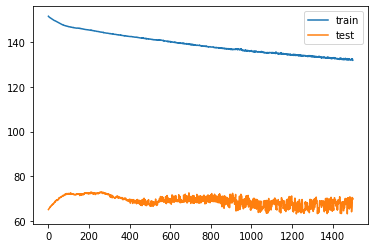

In [25]:
# LSTM model untuk residual
model2 = Sequential()
model2.add(LSTM(50, input_shape=(residual_train_X.shape[1], residual_train_X.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(residual_train_X, residual_train_y, epochs=epooch_residual, batch_size=size_batch, validation_data=(residual_test_X, residual_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [26]:
# make a prediction
yhat_residual = model2.predict(residual_test_X)
yhat_residual

array([[ 39.8438  ],
       [-32.0339  ],
       [-12.626233],
       [-16.584833],
       [-28.149372],
       [  4.752923],
       [-20.355608],
       [-65.22973 ],
       [-18.452127],
       [-15.592145]], dtype=float32)

In [27]:
data_evaluasi

,case
date,
2021-05-05,845
2021-05-06,905
2021-05-07,783
2021-05-08,732
2021-05-09,809
2021-05-10,694
2021-05-11,406
2021-05-12,656
2021-05-13,785


In [28]:
residual_list = ndarray.tolist(yhat_residual)
seasonal_list = ndarray.tolist(yhat_seasonality)
ARIMA_list = hasil['predicted_mean'].tolist()
list_evaluasi = data_evaluasi['case'].tolist()
length = len(list_evaluasi)
hasil_final = list()

for i in range(length):
    residual_single = residual_list[i]
    seasonal_single = seasonal_list[i]
    residual_single = residual_single[0]
    seasonal_single = seasonal_single[0]
    tambah = residual_single+seasonal_single+ARIMA_list[i]
    hasil_final.append(tambah)
    #print('hasil tambah',tambah)

hasil_final

[777.6403068170454,
 701.0660892902832,
 812.3956326707124,
 835.7989524117093,
 837.6056575006188,
 750.3006121944752,
 592.0244014132525,
 678.4319342175271,
 771.0071076956849,
 815.0942314865041]

In [29]:
rmse = mean_squared_error(list_evaluasi, hasil_final, squared=False)
rmse

114.27173961746959

In [30]:
rmse_arima = mean_squared_error(list_evaluasi, ARIMA_list, squared=False)
rmse_arima

146.0332229312683